# Retrieve Images from nutrition5k dataset

The following scripts will copy `1000` valid dishes folder from `nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead`.


In [1]:
!rm -r sample_data
!mkdir imagery imagery/realsense_overhead metadata

rm: cannot remove 'sample_data': No such file or directory
mkdir: cannot create directory ‘imagery’: File exists
mkdir: cannot create directory ‘imagery/realsense_overhead’: File exists
mkdir: cannot create directory ‘metadata’: File exists


I need to manually upload `dish_metadata_cafe1.csv` into `./metadata/`



In [2]:
import pandas as pd
import os
import subprocess

In [3]:
raw_data = pd.read_csv("./metadata/dish_metadata_cafe1.csv", on_bad_lines='skip')
raw_data.head()

,dish_1561662216,300.794281,193.000000,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.80124104,...,0.000424822,0.019754223,0.00424822,ingr_0000000513,millet,3.414345,4.06307055,0.03414345,0.809199765,0.119502075
0,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,0.0,0.0,0.0,ingr_0000000524,parsley,0.752816,0.279295,0.006023,0.04818,0.021832
2,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dishes = raw_data.iloc[:, 0]
dishes_added = []

In [5]:
# count = 0
# destination_dir = './imagery/realsense_overhead'
# for dish in dishes:
#   try:
#     # Copy the dish folder
#     subprocess.run(['gsutil','-m', 'cp', '-r', f'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/{dish}', destination_dir], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     print(f"Copied {dish}")
#     count += 1
#     dishes_added.append(dish)
#     print("Current Count:", count)
#   except subprocess.CalledProcessError as e:
#     print(f"Error copying {dish}: {e}")

#   if count == 1000:
#     break

# Data Processing

Reads the `rgb.png` image from all the dish folders.
Then it uses `cv2` to convert the image into a 3D array with its respective RGB values.  

In [6]:
import pandas as pd
import numpy as np
import os
import subprocess
import cv2

In [7]:
def process_image(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_image

In [8]:
base_dir = "./imagery/realsense_overhead"
dishes_added = []
processed_images = {}
for directory in os.listdir(base_dir):
    directory_path = os.path.join(base_dir, directory)

    if os.path.isdir(directory_path):
        dishes_added.append(directory)
        rgb_image_path = os.path.join(directory_path, "rgb.png")
        if os.path.isfile(rgb_image_path):
            rgb_image = process_image(rgb_image_path)
            processed_images[directory] = rgb_image
        else:
            print(f"Warning: RGB image not found in directory {directory}")

In [9]:
IMAGE_SIZE = processed_images["dish_1556575558"].shape
IMAGE_SIZE

(480, 640, 3)

## Create image dataframe and normalize the pixel

In [10]:
MAX_PIXEL_VALUE = 255
processed_images_df = pd.DataFrame([(k, v.flatten()) for k, v in processed_images.items()], columns=['dish_id', 'image'])

In [11]:
raw_data = pd.read_csv("./metadata/dish_metadata_cafe1.csv", on_bad_lines='skip', header=None, usecols=range(6))
data = raw_data[raw_data[0].isin(dishes_added)]
data.columns = ['dish_id', 'calories', 'mass', 'fat', 'carb', 'protein']
data.head()

,dish_id,calories,mass,fat,carb,protein
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.9560
5,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.0200
21,dish_1559844951,274.335999,122.0,17.906000,22.792000,9.7840
33,dish_1558549008,20.700001,115.0,0.230000,4.485000,1.0350
34,dish_1560453174,329.716248,256.0,18.145134,10.521854,32.1376


In [12]:
data = data.merge(processed_images_df, how='left', on='dish_id')
data.head()

,dish_id,calories,mass,fat,carb,protein,image
0,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.9560,"[133, 136, 137, 135, 138, 139, 138, 138, 138, ..."
1,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.0200,"[50, 47, 44, 51, 48, 45, 54, 51, 48, 51, 48, 4..."
2,dish_1559844951,274.335999,122.0,17.906000,22.792000,9.7840,"[165, 176, 174, 168, 179, 177, 170, 176, 176, ..."
3,dish_1558549008,20.700001,115.0,0.230000,4.485000,1.0350,"[58, 53, 49, 58, 53, 49, 64, 56, 55, 71, 63, 6..."
4,dish_1560453174,329.716248,256.0,18.145134,10.521854,32.1376,"[110, 110, 104, 109, 109, 103, 108, 108, 102, ..."


# Create X_train, y_train, X_test and y_test

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
def reshape_flatten_image(X):
  X_reshape = []
  for x in X:
    x = x.reshape(-1)
    X_reshape.append(x)
  return np.array(X_reshape)

def reshape_image(X):
  X_reshape = []
  for x in X:
    x = x.reshape(-1,1).reshape(IMAGE_SIZE)
    X_reshape.append(x)
  return np.array(X_reshape)

In [15]:
train, test = train_test_split(data, train_size=0.8, random_state=0)

In [16]:
train, validate = train_test_split(train, train_size=0.9, random_state=00)

In [17]:
X_train = reshape_flatten_image(train['image'].values)
y_train = train[['mass', 'calories', 'fat', 'protein', 'carb']].values

In [18]:
X_validate = reshape_flatten_image(validate['image'].values)
y_validate = validate[['mass', 'calories', 'fat', 'protein', 'carb']].values

In [19]:
X_test = reshape_flatten_image(test['image'].values)
y_test = test[['mass', 'calories', 'fat', 'protein', 'carb']].values

## Reshaping flatten image

In [20]:
X_train = reshape_image(X_train)
X_validate = reshape_image(X_validate)
X_test = reshape_image(X_test)

In [21]:
X_train.shape

(717, 480, 640, 3)

# Create Model

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomFlip, RandomContrast, RandomRotation

2024-04-11 22:03:30.392784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
def create_model(input_shape):
    model = Sequential()

    # Pre-trained network (encoder)
    base_model = keras.applications.ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape)

    base_model.trainable = False

    model.add(base_model)

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='linear'))  # 5 neurons for mass, calories, fats, protein, carbs

    return model

# Loss Function

For the model above, we use MSE as the loss function to train the model.\
Now we try out the loss function that was provided in the google paper.

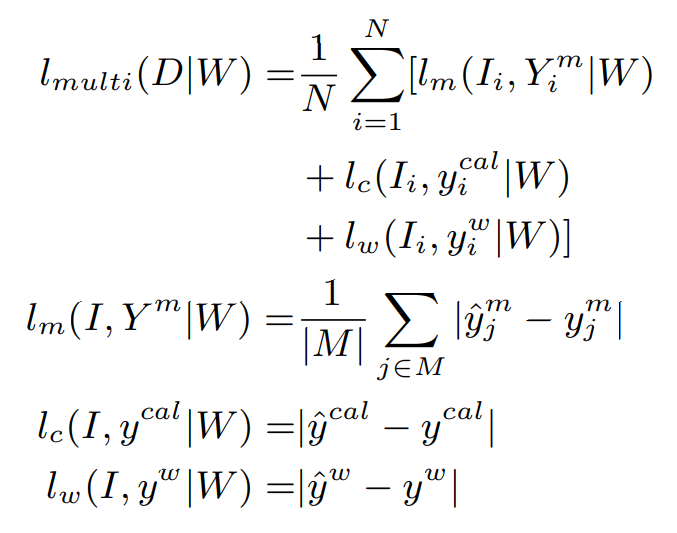

In [24]:
# output = [calories, mass, fat, carb, protein]

def multi_loss(actual, pred):
    actual = tf.squeeze(actual)
    pred = tf.squeeze(pred)

    pred = tf.cast(pred, dtype=actual.dtype)

    temp = tf.abs(actual - pred)

    l_multi = tf.reduce_mean(tf.reduce_sum(temp[:, 2:], axis=1))

    l = tf.reduce_mean(tf.reduce_sum(temp[:, :2], axis=1) + l_multi)

    return l

# multi_loss(y_test, y_pred)

# Train Model

Create a model that uses `adam` optimizer and loss function as `MSE`

In [25]:
epochs = 2
batch_size = 32

In [26]:
# Create the model
model = create_model(IMAGE_SIZE)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

2024-04-11 22:03:35.357420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validate, y_validate))

Epoch 1/2
23/23 [==============================] - 264s 11s/step - loss: 125007840.0000 - mae: 5895.3423 - val_loss: 4867330.5000 - val_mae: 2079.0647
Epoch 2/2
23/23 [==============================] - 289s 13s/step - loss: 2415906.0000 - mae: 1236.9640 - val_loss: 717901.4375 - val_mae: 684.3462


In [28]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 46s 7s/step - loss: 738944.1875 - mae: 699.9249


[738944.1875, 699.9249267578125]

# Train Model

Create a model that uses `adam` optimizer and loss function as `multi_loss`

In [29]:
epochs = 10
batch_size = 32

In [30]:
# Create the model
model = create_model(IMAGE_SIZE)

# Compile the model
model.compile(optimizer='adam', loss=multi_loss, metrics=['mae', multi_loss])

In [31]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validate, y_validate))

Epoch 1/10
23/23 [==============================] - 301s 13s/step - loss: 60796.1016 - mae: 12159.2236 - multi_loss: 59945.8438 - val_loss: 21100.3457 - val_mae: 4220.0693 - val_multi_loss: 21065.2402
Epoch 2/10
23/23 [==============================] - 289s 13s/step - loss: 11142.7607 - mae: 2228.5525 - multi_loss: 11093.5439 - val_loss: 7999.6587 - val_mae: 1599.9319 - val_multi_loss: 8023.8022
Epoch 3/10
23/23 [==============================] - 298s 13s/step - loss: 11208.9932 - mae: 2241.7983 - multi_loss: 11192.4141 - val_loss: 11601.2783 - val_mae: 2320.2556 - val_multi_loss: 11578.0908
Epoch 4/10
23/23 [==============================] - 303s 13s/step - loss: 12417.1826 - mae: 2483.4368 - multi_loss: 12504.7812 - val_loss: 14350.5332 - val_mae: 2870.1067 - val_multi_loss: 14410.3408
Epoch 5/10
23/23 [==============================] - 303s 13s/step - loss: 15062.4893 - mae: 3012.4978 - multi_loss: 14988.5840 - val_loss: 13979.9580 - val_mae: 2795.9915 - val_multi_loss: 13987.7627
E

In [32]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 81s 11s/step - loss: 8241.4785 - mae: 1648.2958 - multi_loss: 8256.4951


[8241.478515625, 1648.2957763671875, 8256.4951171875]

# Train Model

Create a model that uses `RMSProp` optimizer and loss function as `multi_loss`

In [33]:
epochs = 10
batch_size = 32

In [34]:
# Create the model
model = create_model(IMAGE_SIZE)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9, weight_decay=0.9, epsilon=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss=multi_loss, metrics=['mae', multi_loss])

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validate, y_validate))

Epoch 1/10
23/23 [==============================] - 327s 14s/step - loss: 58447.6602 - mae: 11689.5332 - multi_loss: 58012.6641 - val_loss: 65349.5859 - val_mae: 13069.9180 - val_multi_loss: 65419.6055
Epoch 2/10
23/23 [==============================] - 330s 14s/step - loss: 45377.9297 - mae: 9075.5850 - multi_loss: 44888.6016 - val_loss: 29975.8008 - val_mae: 5995.1597 - val_multi_loss: 30206.9609
Epoch 3/10
23/23 [==============================] - 343s 15s/step - loss: 46218.2773 - mae: 9243.6562 - multi_loss: 45977.1641 - val_loss: 27373.7500 - val_mae: 5474.7500 - val_multi_loss: 27421.7285
Epoch 4/10
23/23 [==============================] - 330s 15s/step - loss: 30662.1699 - mae: 6132.4346 - multi_loss: 30898.5605 - val_loss: 32870.2930 - val_mae: 6574.0586 - val_multi_loss: 32996.4219
Epoch 5/10
23/23 [==============================] - 338s 15s/step - loss: 24449.7324 - mae: 4889.9468 - multi_loss: 24271.1992 - val_loss: 26082.3516 - val_mae: 5216.4697 - val_multi_loss: 26126.252

In [1]:
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined